# Street-level image segmentation
In this part, we are going to work on segmentating street-level images into different categories. 



Inport the modules and mount Google Drive

In [ ]:
# import fiona
# import shapely
# import pyproj
# import os, os.path
# from fiona.crs import from_epsg

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import numpy as np
import requests
from PIL import Image
from matplotlib import pyplot as plt
import io
import os, os.path

### Semantic Segmentation

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The code for this notebook is available here
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks

It can be run on Colab at this URL https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

### Environment Setup

First, download the code and pretrained models if we are on colab.

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
# pil_image = PIL.Image.open('ADE_val_00001519.jpg').convert('RGB')
# img_original = numpy.array(pil_image)
# img_data = pil_to_tensor(pil_image)
# singleton_batch = {'img_data': img_data[None].cuda()}
# output_size = img_data.shape[1:]

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

- Building: 1
- Sky: 2
- road: 6
- Tree: 4
- Grass: 9
- sidewalk: 11

In [ ]:
!wget https://utilitiesfiles.s3.us-east-1.amazonaws.com/penn-class/ai-urban-sustainability/data/gsvimages.zip -O gsvimgs.zip
!unzip -q gsvimgs.zip -d 'gsvimgs/'
!rm gsvimgs.zip

--2025-12-07 20:36:13--  https://utilitiesfiles.s3.us-east-1.amazonaws.com/penn-class/ai-urban-sustainability/data/gsvimages.zip
Resolving utilitiesfiles.s3.us-east-1.amazonaws.com (utilitiesfiles.s3.us-east-1.amazonaws.com)... 52.216.9.222, 54.231.128.130, 16.15.187.211, ...
Connecting to utilitiesfiles.s3.us-east-1.amazonaws.com (utilitiesfiles.s3.us-east-1.amazonaws.com)|52.216.9.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21495086 (20M) [application/zip]
Saving to: ‘gsvimgs.zip’

gsvimgs.zip         100%[===================>]  20.50M  7.24MB/s    in 2.8s    

2025-12-07 20:36:17 (7.24 MB/s) - ‘gsvimgs.zip’ saved [21495086/21495086]



In [ ]:
from pathlib import Path
import pandas as pd
import os

# Root folder in your Google Drive
base_dir = Path('/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m')

# CSV that has image_file and image_path columns
csv_path = base_dir / "street_points_250m_with_images.csv"
meta = pd.read_csv(csv_path)

print("Loaded metadata rows:", len(meta))
print(meta.columns)

# Build absolute image path from the relative image_path in CSV
meta["abs_image_path"] = meta["image_path"].apply(lambda p: str(base_dir / p))

# Quick check: show first few paths
meta[["image_file", "image_path", "abs_image_path"]].head()


Loaded metadata rows: 178
Index(['city', 'street', 'segment_id', 'point_id', 'distance_m', 'lon', 'lat',
       'heading_road', 'heading_sidewalk_right', 'heading_sidewalk_left',
       'image_file', 'image_path', 'gsv_status', 'gsv_url_sidewalk'],
      dtype='object')


,image_file,image_path,abs_image_path
0,idx0000_seg0_pt0_h189.jpg,gsv_sidewalk_250m\idx0000_seg0_pt0_h189.jpg,/content/drive/MyDrive/Colab_Notebooks/final/s...
1,idx0001_seg0_pt1_h189.jpg,gsv_sidewalk_250m\idx0001_seg0_pt1_h189.jpg,/content/drive/MyDrive/Colab_Notebooks/final/s...
2,idx0002_seg0_pt2_h189.jpg,gsv_sidewalk_250m\idx0002_seg0_pt2_h189.jpg,/content/drive/MyDrive/Colab_Notebooks/final/s...
3,idx0003_seg0_pt3_h189.jpg,gsv_sidewalk_250m\idx0003_seg0_pt3_h189.jpg,/content/drive/MyDrive/Colab_Notebooks/final/s...
4,idx0004_seg0_pt4_h189.jpg,gsv_sidewalk_250m\idx0004_seg0_pt4_h189.jpg,/content/drive/MyDrive/Colab_Notebooks/final/s...


In [ ]:
# gsvdir = os.path.join(root, 'gsvimgs')
# gsvdir
from pathlib import Path

base_dir = Path('/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m')
gsvdir = base_dir / "gsv_sidewalk_250m"
files = os.listdir(gsvdir)

# Print total number of images
print("Number of image files:", len(files))

# Optional: print first few filenames to check
for f in files[:5]:
    print(f)

Number of image files: 178
idx0000_seg0_pt0_h189.jpg
idx0001_seg0_pt1_h189.jpg
idx0002_seg0_pt2_h189.jpg
idx0003_seg0_pt3_h189.jpg
idx0004_seg0_pt4_h189.jpg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pathlib import Path

base_dir = Path('/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m')
img_dir = base_dir / "gsv_sidewalk_250m"

# 从 image_path 里提取出纯文件名（兼容 Windows 的反斜杠）
meta["image_file"] = meta["image_path"].apply(
    lambda p: os.path.basename(str(p).replace("\\", "/"))
)

# 用真正的图片文件夹 + 文件名 拼出绝对路径
meta["abs_image_path"] = meta["image_file"].apply(
    lambda f: str(img_dir / f)
)

print(meta[["image_path", "image_file", "abs_image_path"]].head())


                                    image_path                 image_file  \
0  gsv_sidewalk_250m\idx0000_seg0_pt0_h189.jpg  idx0000_seg0_pt0_h189.jpg   
1  gsv_sidewalk_250m\idx0001_seg0_pt1_h189.jpg  idx0001_seg0_pt1_h189.jpg   
2  gsv_sidewalk_250m\idx0002_seg0_pt2_h189.jpg  idx0002_seg0_pt2_h189.jpg   
3  gsv_sidewalk_250m\idx0003_seg0_pt3_h189.jpg  idx0003_seg0_pt3_h189.jpg   
4  gsv_sidewalk_250m\idx0004_seg0_pt4_h189.jpg  idx0004_seg0_pt4_h189.jpg   

                                      abs_image_path  
0  /content/drive/MyDrive/Colab_Notebooks/final/s...  
1  /content/drive/MyDrive/Colab_Notebooks/final/s...  
2  /content/drive/MyDrive/Colab_Notebooks/final/s...  
3  /content/drive/MyDrive/Colab_Notebooks/final/s...  
4  /content/drive/MyDrive/Colab_Notebooks/final/s...  


### Applying segmentation model to street-view images to obtain class masks and output


/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0000_seg0_pt0_h189.jpg


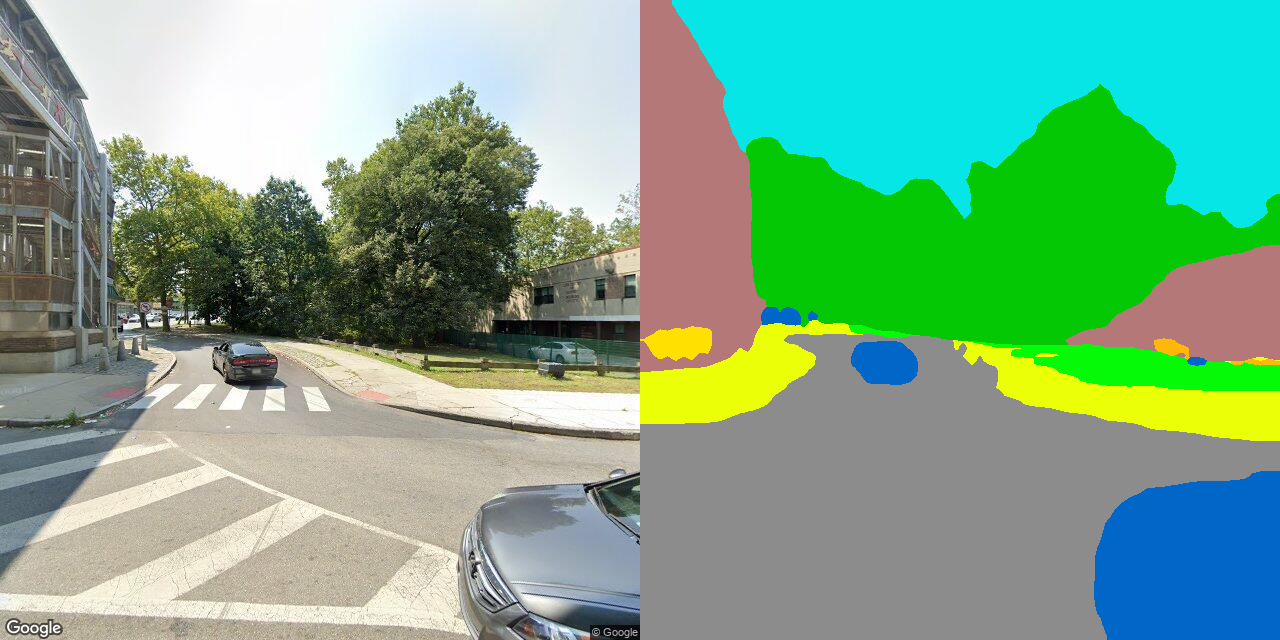

/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0001_seg0_pt1_h189.jpg


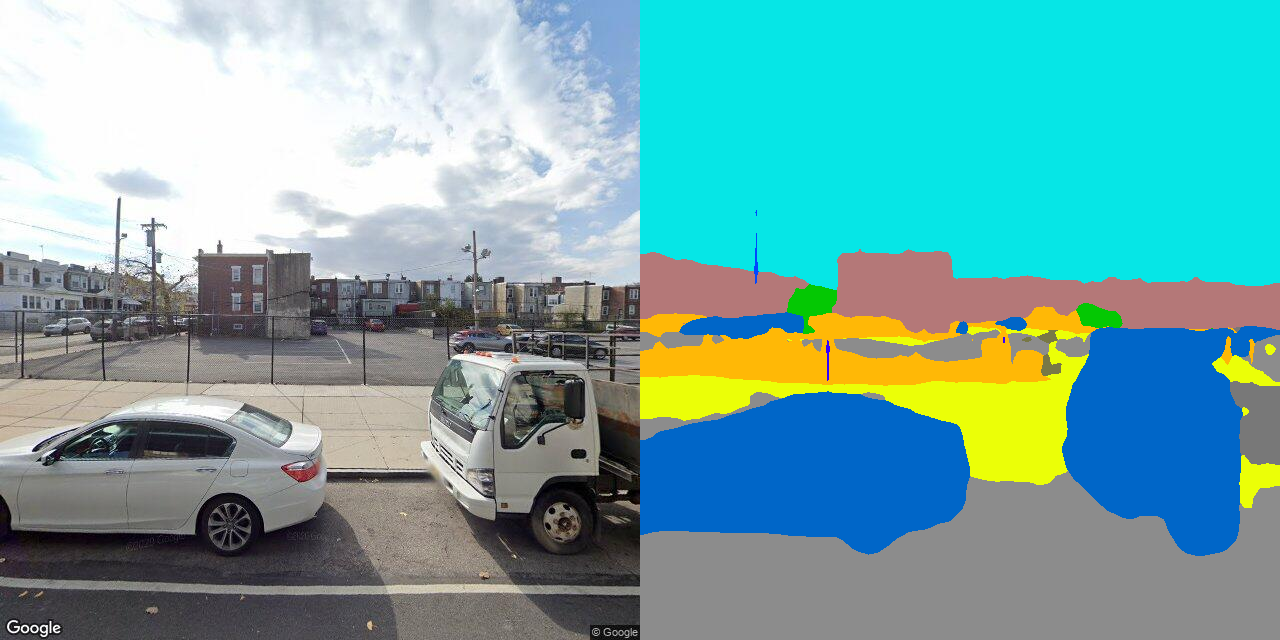

/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0002_seg0_pt2_h189.jpg


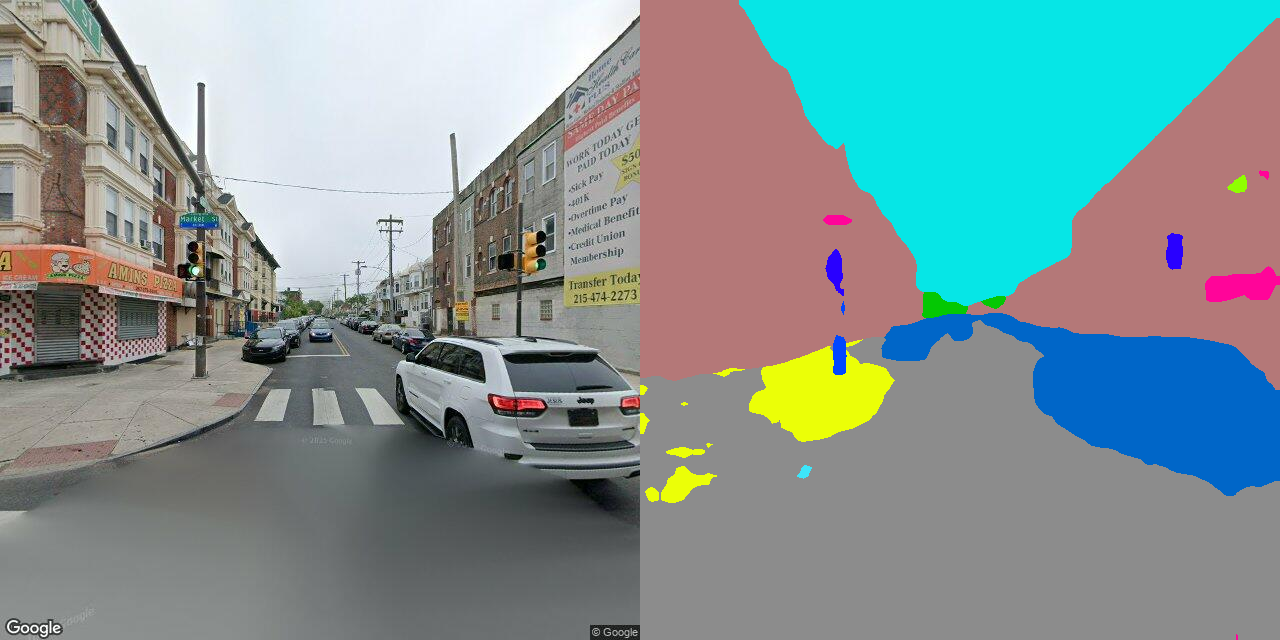

/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0003_seg0_pt3_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0004_seg0_pt4_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0005_seg0_pt5_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0006_seg0_pt6_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0007_seg0_pt7_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0008_seg0_pt8_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0009_seg0_pt9_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0010_seg0_pt10_h189.jpg
/content/drive/MyDrive/Colab_Notebooks/final/street_samples_250m/gsv_sidewalk_250m/idx0011_seg0_pt11_h189.jpg
/content/drive/My

In [ ]:
import os
import numpy as np
import PIL.Image

# 1. Initialize empty columns for segmentation fractions
meta["building_frac"] = np.nan
meta["sky_frac"]      = np.nan
meta["road_frac"]     = np.nan
meta["tree_frac"]     = np.nan
meta["grass_frac"]    = np.nan
meta["sidewalk_frac"] = np.nan

# 2. Columns to store processed (segmentation visualization) image info
meta["seg_vis_file"] = ""
meta["seg_vis_path"] = ""

# 3. Folder to save processed images (original + segmentation)
seg_vis_dir = base_dir / "gsv_sidewalk_250m_segvis"
seg_vis_dir.mkdir(exist_ok=True)

# 4. Loop over each row in the CSV
for idx, row in meta.iterrows():
    filename = row["abs_image_path"]
    print(filename)

    # Optional: test only a few images first
    # if idx > 5:
    #     break

    # --- load image ---
    pil_image = PIL.Image.open(filename).convert('RGB')
    img_original = np.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    # --- run segmentation ---
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # predicted label per pixel (H, W), each in [0, 149]
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()

    # ---- compute pixel fractions for selected classes ----
    flat = pred.flatten()
    total_pixels = flat.size
    class_counts = np.bincount(flat, minlength=150)
    class_frac = class_counts / total_pixels

    # ADE20K class indices:
    # 1: building, 2: sky, 3: road, 4: tree, 9: grass, 11: sidewalk
    meta.loc[idx, "building_frac"] = float(class_frac[1])
    meta.loc[idx, "sky_frac"]      = float(class_frac[2])
    meta.loc[idx, "road_frac"]     = float(class_frac[6])
    meta.loc[idx, "tree_frac"]     = float(class_frac[4])
    meta.loc[idx, "grass_frac"]    = float(class_frac[9])
    meta.loc[idx, "sidewalk_frac"] = float(class_frac[11])

    # ---- create and save visualization image (original + segmentation) ----
    # colorEncode and colors come from the MIT ADE20K code you ran earlier
    pred_color = colorEncode(pred, colors).astype(np.uint8)
    im_vis = np.concatenate((img_original, pred_color), axis=1)

    # use image_file as base name if available
    if "image_file" in meta.columns and isinstance(row["image_file"], str):
        vis_name = f"seg_{row['image_file']}"
    else:
        vis_name = f"seg_idx{idx:04d}.jpg"

    vis_path = seg_vis_dir / vis_name
    PIL.Image.fromarray(im_vis).save(vis_path)

    # store processed image info (relative path is enough)
    meta.loc[idx, "seg_vis_file"] = vis_name
    meta.loc[idx, "seg_vis_path"] = str(vis_path)

    # ---- (optional) visualize in notebook for the first few images ----
    if idx < 3:
        visualize_result(img_original, pred)

print("Segmentation + saving finished for all rows.")

# 5. Save updated CSV with fractions and processed image paths
out_csv = base_dir / "street_points_250m_with_seg_features.csv"
meta.to_csv(out_csv, index=False)

print("Saved updated CSV to:")
print(" ", out_csv)
